# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError
import math

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sigmoid = 1/(1 + math.e**(-weights @ X.T))
        return sigmoid
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss = np.mean(np.log(1 + np.exp(-weights @ x.T * y))) + (1/(self.C*2)) * np.linalg.norm(weights)**2
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
#         for i in range(self.max_iter):
#             delta = (y @ X_ext * (1 - 1/(1 + np.exp(-self.weights_ @ X_ext.T @ y))) - self.weights_/self.C)/ y.shape[0]
#             self.weights_ += self.eta * delta
#             if np.linalg.norm(self.eta * delta) < self.tol:
#                 break
        self.loss_history = []
        for i in range(self.max_iter):
            sum_d = 0
            for j in range(y.shape[0]):
                d = y[j] * X_ext[j] *(1 - 1/(1 + np.exp(-self.weights_ @ X_ext[j] * y[j]))) 
                sum_d +=d
            delta = sum_d/y.shape[0] - self.weights_/self.C
            self.weights_ += self.eta * delta
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
            
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_list = []
        for i in self.predict_proba(X):
            if i > 0.5:
                y_list.append(1)
            else:
                y_list.append(-1)
        return y_list

In [5]:
from sklearn import datasets
from sklearn import metrics

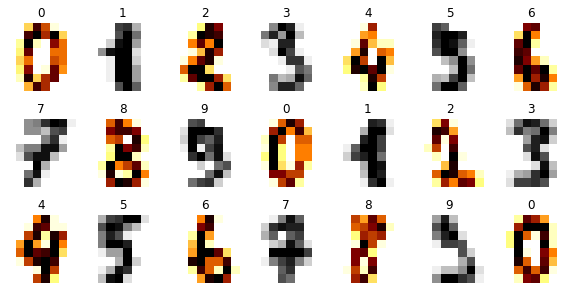

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

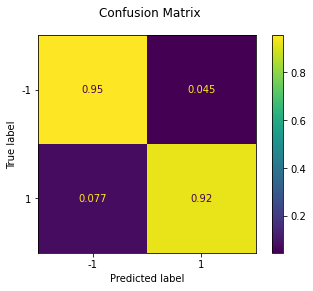

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

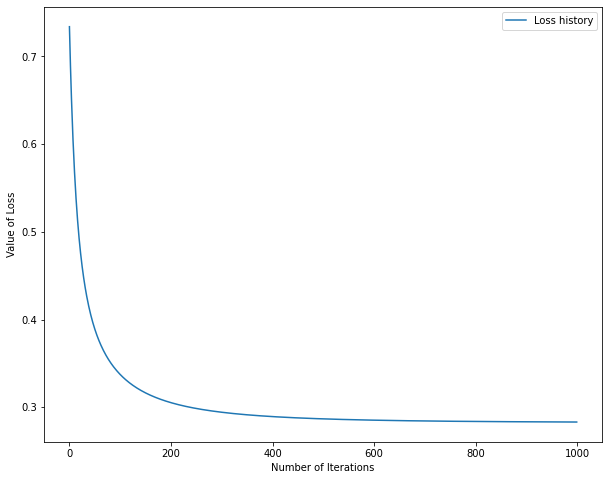

In [18]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(model.loss_history, label = 'Loss history')
plt.xlabel('Number of Iterations');
plt.ylabel('Value of Loss');
plt.legend();

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

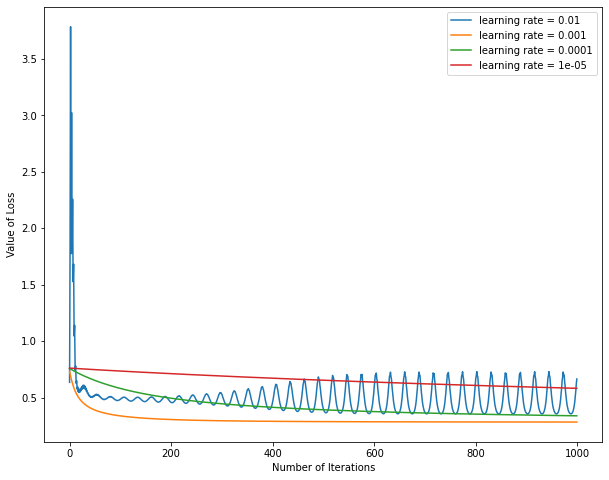

In [19]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
for i in learning_rates:
    lr_change = CustomLogisticRegression(eta=i)
    lr_change.fit(X_train, y_train)
    plt.plot(lr_change.loss_history, label = 'learning rate = ' + str(i))
plt.xlabel('Number of Iterations');
plt.ylabel('Value of Loss');
plt.legend();

As we can see from the plot with lower learning rates the loss improves much slower than with higher learning rates. <br>
The loss which uses learning rate of 0.01 plummets after the first iterations, while the losses which use learning rates of 0.001, 0.0001, and 0.00001 converge much more smoothly.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

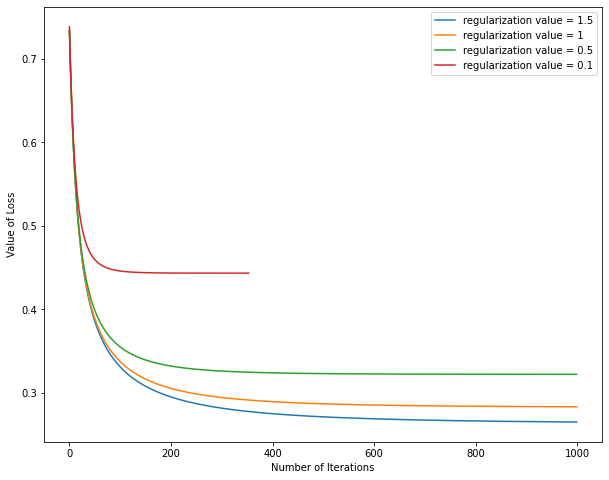

In [20]:
regularization_values = [1.5, 1, 0.5, 0.1]
for i in regularization_values:
    c_change = CustomLogisticRegression(C=i)
    c_change.fit(X_train, y_train)
    plt.plot(c_change.loss_history, label = 'regularization value = ' + str(i))
plt.xlabel('Number of Iterations');
plt.ylabel('Value of Loss');
plt.legend();

In [21]:
regularization_values = [1.5, 1.0, 0.5, 0.1]
for i in regularization_values:
    c_change = CustomLogisticRegression(C=i)
    c_change.fit(X_train, y_train)
    train_acc, test_acc = metrics.accuracy_score(y_pred=c_change.predict(X_train), y_true=y_train), \
                          metrics.accuracy_score(y_pred=c_change.predict(X_test), y_true=y_test)
    print(f'C = {i} : train_acc is {train_acc}, test_acc is {test_acc}')

C = 1.5 : train_acc is 0.9130132219902575, test_acc is 0.9416666666666667
C = 1.0 : train_acc is 0.9109255393180237, test_acc is 0.9388888888888889
C = 0.5 : train_acc is 0.9039665970772442, test_acc is 0.9277777777777778
C = 0.1 : train_acc is 0.8872651356993737, test_acc is 0.9138888888888889


According to the plot, lower regularization parameter values result in higher loss values.<br>
The same we can notice in the train and test accuracy, the lower the C parameter the lower the accuracy.

**(0.5 points)** Compare zero initialization and random initialization. 

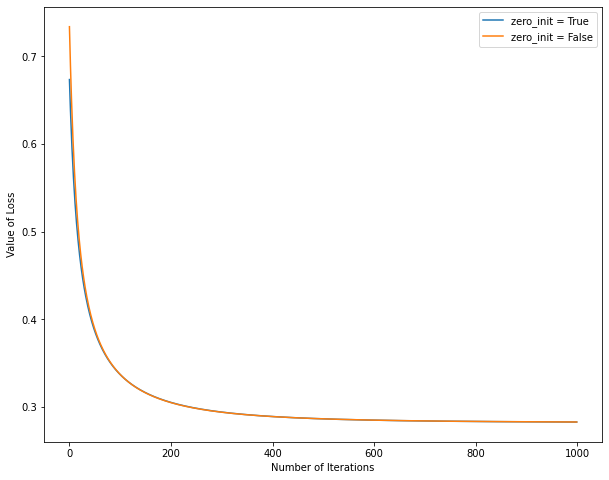

In [22]:
zero_init = [True, False]
for i in zero_init:
    zero_change = CustomLogisticRegression(zero_init=i)
    zero_change.fit(X_train, y_train)
    plt.plot(zero_change.loss_history, label = 'zero_init = ' + str(i))
plt.xlabel('Number of Iterations');
plt.ylabel('Value of Loss');
plt.legend();

As we can see from the plot, zero initialization and random initialization produce very similar loss, however with zero initialization we get slightly lower loss on the first iterations.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [30]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        i = X.shape[0]
        j = Y.shape[0]
        x_sqr = (X * X).sum(axis=1).reshape((i,1)) * np.ones(shape=(1,j))
        y_sqr = (Y * Y).sum(axis=1) * np.ones(shape=(i,1))
        d_sqr =  x_sqr + y_sqr - 2 * X @ Y.T
        return d_sqr**(1/2)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """

        df = pd.DataFrame(weights, y)
        dict_map = {'zero': 0, 'one': 1 , 'two':2,'three':3, 'four':4, 'five':5,'six':6, 'seven':7,'eight':8,'nine':9}
#         dict_map2 = {'0': 0, '1': 1 , '2':2,'3':3, '4':4, '5':5,'6':6, '7':7,'8':8,'9':9}
        df = pd.DataFrame(weights, y)
        if df.index[0] in ['zero', 'one', 'two', 'three', 'four', 'five','six', 'seven','eight','nine']:
            df.index = df.index.map(dict_map)
        df.sort_index(axis=0, inplace=True)
        sum_w = df.groupby(df.index).sum('0')
        return sum_w[0].to_list()
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
#             P = get_pairwise_distances(X, X) 
#             class_weights = get_class_weights(self.y, self.y)
#             prob = weights_of_points/sum(class_weights)
            pass
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
#         return prob
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [33]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

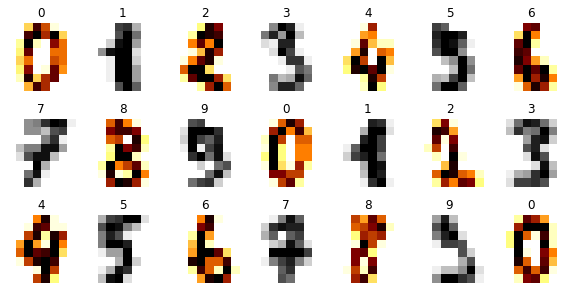

In [34]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [35]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

### The rest isn't implemented, so I've commented asserts out to avoid errors. Please check out EDA in the 3rd task.

In [39]:
# assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [40]:
# train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [41]:
# assert train_acc == 1
# assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [42]:
PATH = "./data/"

In [43]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [44]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Let's count how many females and males are there in the dataset and visualize the counts:

In [45]:
sex_cnt = data['Sex'].value_counts()
sex_cnt

male      56114
female    43886
Name: Sex, dtype: int64

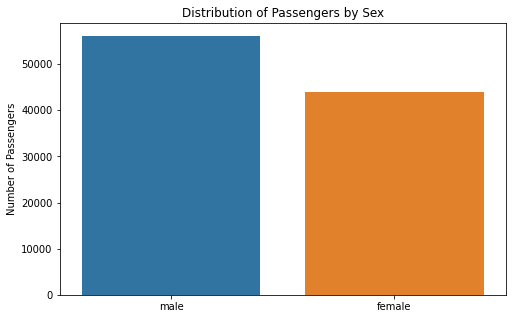

In [46]:
plt.figure(figsize=(8,5))
plt.title("Distribution of Passengers by Sex")
sns.barplot(x = sex_cnt.index, y = sex_cnt)
plt.ylabel("Number of Passengers");

Let's count how many passengers survived and visualize the counts:

In [47]:
survived_cnt = data['Survived'].value_counts()
survived_cnt

0    57226
1    42774
Name: Survived, dtype: int64

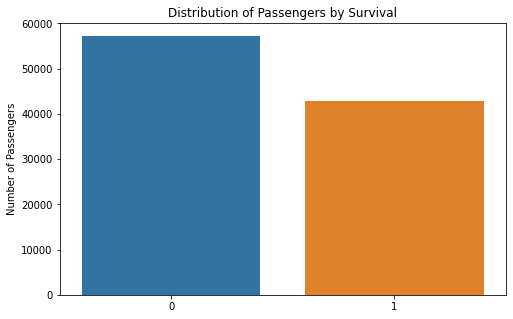

In [48]:
plt.figure(figsize=(8,5))
plt.title("Distribution of Passengers by Survival")
sns.barplot(x = survived_cnt.index, y = survived_cnt)
plt.ylabel("Number of Passengers");

Let's visualise survival by sex:

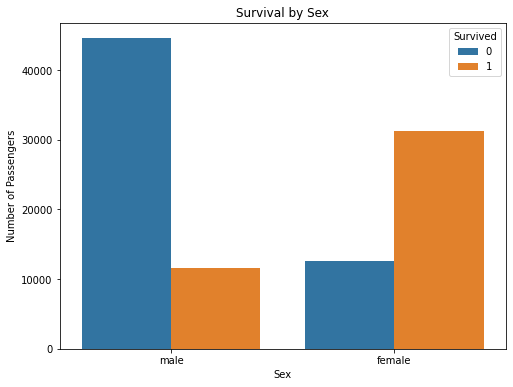

In [49]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax_sex_survived = fig.add_subplot(gs[:2,:2])
sns.countplot(x='Sex', hue='Survived', data=data, ax=ax_sex_survived)
plt.title("Survival by Sex")
plt.ylabel("Number of Passengers")
plt.show()

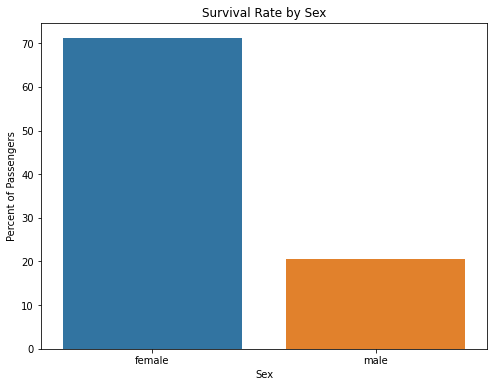

In [50]:
passenger_sex =data[['Sex', 'Survived']].groupby('Sex')['Survived'].value_counts().sort_index().unstack().fillna(0)
passenger_sex['Survival rate'] = passenger_sex[1] / (passenger_sex[0] + passenger_sex[1]) * 100
plt.figure(figsize=(8, 6))
plt.title("Survival Rate by Sex")
sns.barplot(x = passenger_sex.index, y = passenger_sex['Survival rate'])
plt.ylabel("Percent of Passengers")
plt.show()

We can see from the plots that there's relationship between gender and survival. There are more females among survivors than males. More than 70% of females survived, while only about 20% of males survived. This can be explained by the fact that women were a priority for resque from the ship.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

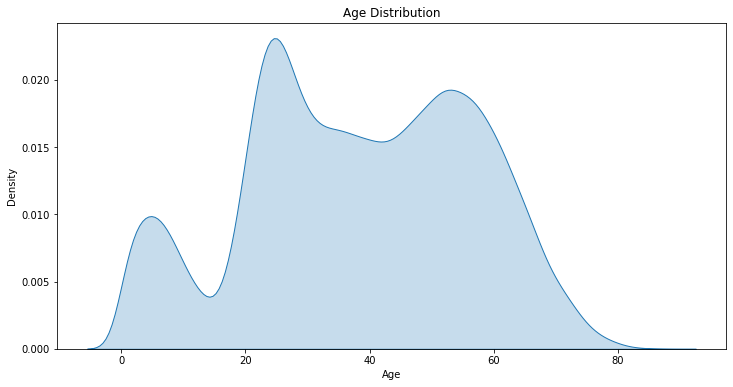

In [51]:
plt.figure(figsize=(12,6))
sns.kdeplot(x='Age',data=data, shade=True).set_title("Age Distribution")
plt.show()

In [52]:
CentralTendency_Age = {}
CentralTendency_Age['Mean'] = data['Age'].mean()
CentralTendency_Age['Median'] = data['Age'].median()
CentralTendency_Age['Mode'] = data['Age'].mode()[0]
CentralTendency_Age

{'Mean': 38.35547214294576, 'Median': 39.0, 'Mode': 25.0}

The average and median age of passengers are almost the same. However the most common age is 25 years.

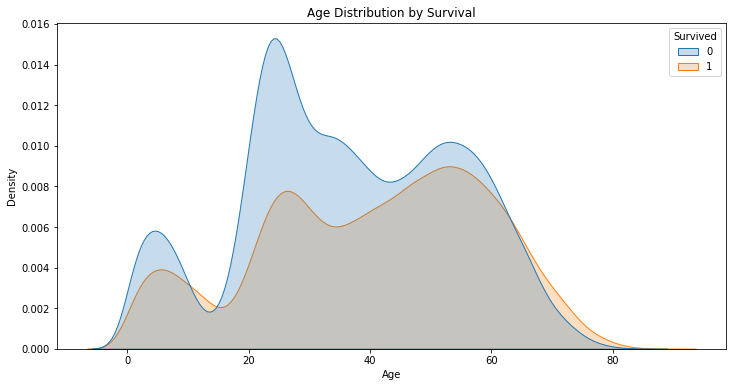

In [53]:
plt.figure(figsize=(12,6))
sns.kdeplot(x='Age',data=data, hue='Survived', shade=True).set_title("Age Distribution by Survival")
plt.show()

We can see from the plot above that age distributions differ for survived and deceased passengers. For almost all ages more passenger deceased than survived, but for age about 10-15 and for age greater than about 65 more passenger survived than deceased. This can be explained by the assumption that the children were preffered to be resqued from the ship, and that most of the elderly passengers in the first class cabins, which were closer to the deck, and had more chances to survive.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

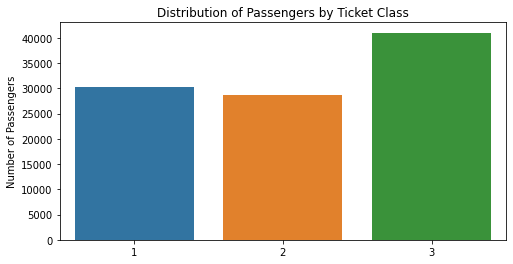

In [54]:
pclass_cnt = data['Pclass'].value_counts()
plt.figure(figsize=(8,4))
plt.title("Distribution of Passengers by Ticket Class")
sns.barplot(x = pclass_cnt.index, y = pclass_cnt)
plt.ylabel("Number of Passengers");

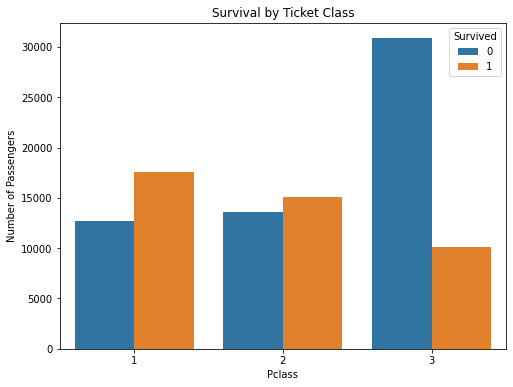

In [55]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax_pclass_survived = fig.add_subplot(gs[:2,:2])
sns.countplot(x='Pclass', hue='Survived', data=data, ax=ax_pclass_survived)
plt.title("Survival by Ticket Class")
plt.ylabel("Number of Passengers")
plt.show()

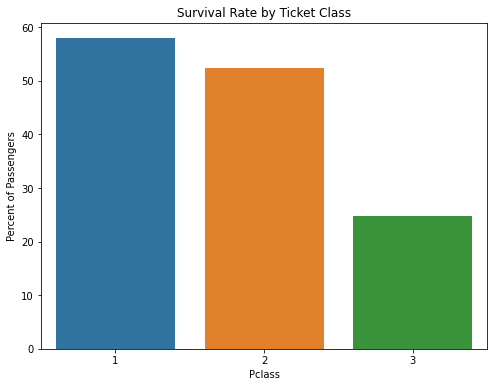

In [56]:
passenger_pclass =data[['Pclass', 'Survived']].groupby('Pclass')['Survived'].value_counts().sort_index().unstack().fillna(0)
passenger_pclass['Survival rate'] = passenger_pclass[1] / (passenger_pclass[0] + passenger_pclass[1]) * 100
plt.figure(figsize=(8, 6))
plt.title("Survival Rate by Ticket Class")
sns.barplot(x = passenger_pclass.index, y = passenger_pclass['Survival rate'])
plt.ylabel("Percent of Passengers")
plt.show()

According to the plots above the 1st class was the safest because it has the greates survival rate (almost 60%) comparing to other classes. The resont for this may be that the 1st class cabins were higher levels on the ship, while the 2nd and 3rd class cabins were  on the lower levels, so the passengers in the 2nd and 3rd class coulnd get out of their cabins because the lower levels of the ship were flooded with water.

Text(0, 0.5, 'Number of Passengers')

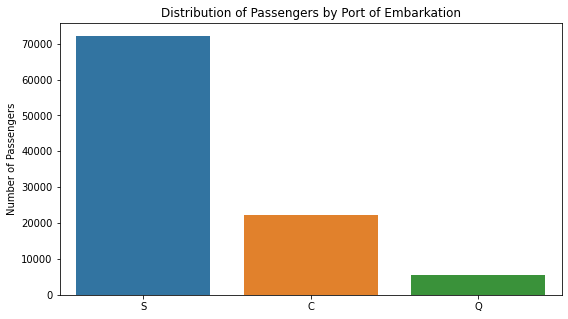

In [57]:
embarked_cnt = data['Embarked'].value_counts()
plt.figure(figsize=(9,5))
plt.title("Distribution of Passengers by Port of Embarkation")
sns.barplot(x = embarked_cnt.index, y = embarked_cnt)
plt.ylabel("Number of Passengers")

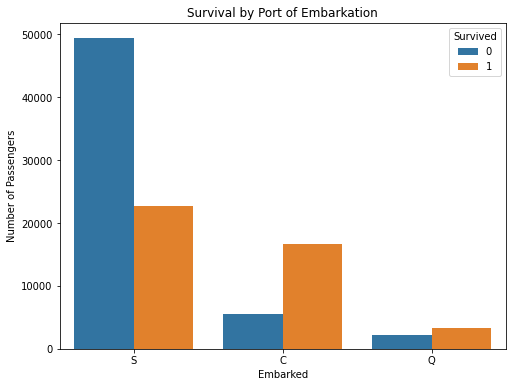

In [58]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax_embarked_survived = fig.add_subplot(gs[:2,:2])
sns.countplot(x='Embarked', hue='Survived', data=data, ax=ax_embarked_survived)
plt.title("Survival by Port of Embarkation")
plt.ylabel("Number of Passengers")
plt.show()

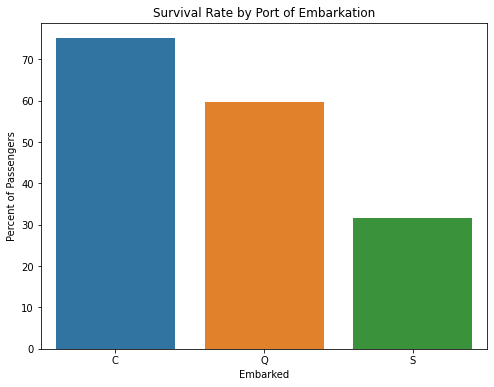

In [59]:
passenger_embarked =data[['Embarked', 'Survived']].groupby('Embarked')['Survived'].value_counts().sort_index().unstack().fillna(0)
passenger_embarked['Survival rate'] = passenger_embarked[1] / (passenger_embarked[0] + passenger_embarked[1]) * 100
plt.figure(figsize=(8, 6))
plt.title("Survival Rate by Port of Embarkation")
sns.barplot(x = passenger_embarked.index, y = passenger_embarked['Survival rate'])
plt.ylabel("Percent of Passengers")
plt.show()

According to the plots above the highest survival rate for for the Cherbourg port of embarkation (more than 70%). This can be explained by the fact that more passengers from the 1st class were embarked in Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.